In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import mediapipe as mp
import cv2



In [ ]:
model = keras.Squential

NameError: name 'core' is not defined

In [2]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    cv2.imshow('frame', frame)
    cv2.putText(frame, f'frame', (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Hand landmark mediapipe

In [ ]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# For static images:
IMAGE_FILES = []
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
  for idx, file in enumerate(IMAGE_FILES):
    # Read an image, flip it around y-axis for correct handedness output (see
    # above).
    image = cv2.flip(cv2.imread(file), 1)
    # Convert the BGR image to RGB before processing.
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print handedness and draw hand landmarks on the image.
    print('Handedness:', results.multi_handedness)
    if not results.multi_hand_landmarks:
      continue
    image_height, image_width, _ = image.shape
    annotated_image = image.copy()
    for hand_landmarks in results.multi_hand_landmarks:
      print('hand_landmarks:', hand_landmarks)
      print(
          f'Index finger tip coordinates: (',
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
      )
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
    cv2.imwrite(
        '/tmp/annotated_image' + str(idx) + '.png', cv2.flip(annotated_image, 1))
    # Draw hand world landmarks.
    if not results.multi_hand_world_landmarks:
      continue
    for hand_world_landmarks in results.multi_hand_world_landmarks:
      mp_drawing.plot_landmarks(
        hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()

: 

# Training model

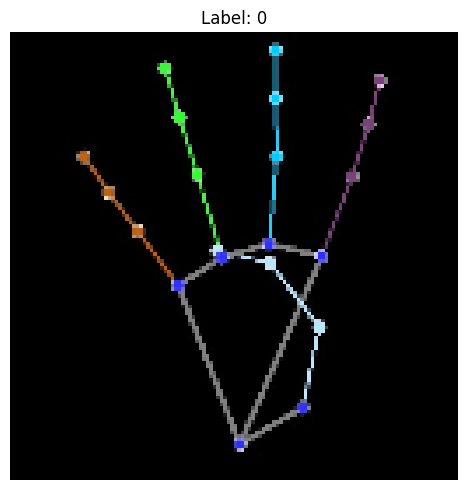

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define dataset path
DATASET_PATH = 'data/processed_combine_asl_dataset'

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20


# Function to load dataset
def load_dataset(dataset_path):
    images = []
    labels = []

    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(1 if label == 'palm' else 0)

    images = np.array(images) / 255.0
    labels = np.array(labels)
    return images, labels

# Load dataset
X, y = load_dataset(DATASET_PATH)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display some training images
unique_labels = np.unique(y_train)
plt.figure(figsize=(10, 5))
for label in unique_labels:
    index = np.where(y_train == label)[0][0]
    plt.subplot(1, len(unique_labels), label + 1)
    plt.imshow(X_train[index])
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

#Focal loss
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)
                      + (1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed


# CNN Model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(), loss=focal_loss(gamma=2., alpha=.25), metrics=['accuracy'])
    return model

# Initialize and train the model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
model = create_cnn_model(input_shape)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# Save model
model.save('palm_detector_cnn.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
import os
import tensorflow as tf
import mediapipe as mp
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Initialize MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_hand_landmarks(image, hands):
    """Extract hand landmarks from an image using MediaPipe"""
    # Convert the BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image and detect hands
    results = hands.process(image_rgb)

    # Initialize landmarks array
    landmarks = np.zeros((21, 3))  # 21 landmarks, each with x, y, z coordinates

    if results.multi_hand_landmarks:
        # Get the first hand detected
        hand_landmarks = results.multi_hand_landmarks[0]

        # Draw landmarks on the image (for visualization)
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS)

        # Extract landmark coordinates
        for idx, landmark in enumerate(hand_landmarks.landmark):
            landmarks[idx] = [landmark.x, landmark.y, landmark.z]

    return landmarks.flatten(), image  # Return both landmarks and annotated image

def load_and_preprocess_dataset(dataset_path):
    """Load and preprocess images to hand landmarks"""
    X_landmarks = []
    labels = []

    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_path}")

    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.5) as hands:

        for label in os.listdir(dataset_path):
            label_path = os.path.join(dataset_path, label)
            if not os.path.isdir(label_path):
                continue

            print(f"Processing {label} images...")
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                # Read image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue

                # Extract landmarks
                landmarks, _ = extract_hand_landmarks(image, hands)

                # Add to dataset if hand was detected (non-zero landmarks)
                if np.any(landmarks):
                    X_landmarks.append(landmarks)
                    labels.append(1 if label == 'palm' else 0)

    if not X_landmarks:
        raise ValueError("No valid hand landmarks were detected in the dataset")

    return np.array(X_landmarks), np.array(labels)

def create_landmark_model(input_shape):
    """Create model for landmark-based classification"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def test_real_time():
    """Real-time testing with webcam"""
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam")
        return

    with mp_hands.Hands(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as hands:

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame")
                break

            # Extract landmarks and get annotated frame
            landmarks, annotated_frame = extract_hand_landmarks(frame, hands)

            # Make prediction if hand is detected
            if np.any(landmarks):
                prediction = model.predict(landmarks.reshape(1, -1), verbose=0)[0]
                label = "Palm" if prediction > 0.5 else "Not Palm"
                confidence = prediction if prediction > 0.5 else 1 - prediction

                # Draw prediction
                cv2.putText(annotated_frame, f"{label}: {confidence:.2f}",
                           (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                           (0, 255, 0), 2)

            # Display frame
            cv2.imshow('Hand Landmark Detection', annotated_frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

def main():
    # Training parameters
    DATASET_PATH = 'data/processed_combine_asl_dataset'
    EPOCHS = 50
    BATCH_SIZE = 32

    try:
        # Load and preprocess dataset
        print("Loading and preprocessing dataset...")
        X, y = load_and_preprocess_dataset(DATASET_PATH)

        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train model
        input_shape = X_train.shape[1]
        model = create_landmark_model(input_shape)

        print("Training model...")
        history = model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # Save model
        model.save('hand_landmark_detector.h5')
        print("Model saved as 'hand_landmark_detector.h5'")

        # Plot training history
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Run real-time testing
        print("Starting real-time testing... Press 'q' to quit")
        test_real_time()

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

Loading and preprocessing dataset...
Processing 0 images...
Processing 1 images...
Processing 2 images...
Processing 3 images...
Processing 4 images...
Processing 5 images...
Processing 6 images...
Processing 7 images...
Processing 8 images...
Processing 9 images...
Processing a images...
Error: No valid hand landmarks were detected in the dataset
